<img src="https://www.sims.edu/assets/images/sims_logo_cc.png" class="center" style="height:350px">

# <div style="color:white;display:fill;border-radius:5px;background-color:#67A4A4;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:120%;text-align:center">Introduction</p></div>

## <b><span style='color:#4F9898'>Business Goal</span> </b>
To assist a supermarket increase their membership card conversion rate, I will explore different clustering techniques and perform a customer segmentation analysis. Customer segmentation describes the process of identifying similar groups of customers based on commonalities like shopping preferences and purchasing history and allows companies to market to each group more effectively. In this notebook, I will develop several clustering models to gain a better understanding of the types of customers the company has and identify strategies to increase their membership conversion rate, including K-Means Clustering and Hierarchical Clustering.

<br>

## <b><span style='color:#4F9898'>Data Overview</span> </b>

The dataset consists of 1111 customers with information related to their age, gender, annual income, and spending score. This is a hypothetical data made by me on the basis of a smaller authentic dataset, therefore this can even reflect the real time analysis. The spending score is a numeric variable ranging from 1 to 100 and was assigned to customers based on behavior parameters and purchasing data. The data set also contains the customer's ID, which will be dropped before beginning the analysis. 

In [2]:
import os, warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import plotly.express as px
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    from plotly.subplots import make_subplots
    from plotly.offline import plot, iplot, init_notebook_mode
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from scipy.cluster import hierarchy
    from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
warnings.filterwarnings("ignore")
cust = pd.read_csv('MyMall_Customers.csv', sep=',')
cust.rename(columns={"Annual Income (k$)": "Annual Income", "Spending Score (1-100)": "Spending Score"}, inplace=True)
print("There are {:,} observations and {} columns in the data set.".format(cust.shape[0], cust.shape[1]))
print("There are {} missing values in the data.".format(cust.isna().sum().sum()))
cust.head()

There are 1,111 observations and 5 columns in the data set.
There are 0 missing values in the data.


,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<b><span style='color:#4F9898'>Data Summary</span></b>

In [3]:
cust.drop('CustomerID', axis=1, inplace=True)
pd.DataFrame(cust.describe()).style.set_caption("Summary Statistics of Numeric Variables")

,Age,Annual Income,Spending Score
count,1111.000000,1111.000000,1111.000000
mean,36.718272,61.985599,44.101710
std,10.515146,20.546843,18.461050
min,18.000000,15.000000,1.000000
25%,28.000000,45.000000,29.000000
50%,36.000000,62.000000,45.000000
75%,45.000000,78.000000,58.000000
max,70.000000,137.000000,99.000000


In [4]:
cust['Gender'] = ['Women' if i == 'Female' else 'Men' for i in cust.Gender]
pd.DataFrame(cust.select_dtypes('object').describe().T).style.set_caption("Summary Statistics of Categorical Variables")

,count,unique,top,freq
Gender,1111,2,Women,606


# <div style="color:white;display:fill;border-radius:5px;background-color:#67A4A4;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:120%;text-align:center">Clustering Models</p></div>
## <b> <span style='color:#707575'>I. </span><span style='color:#4F9898'> K-Means Clustering</span></b>
The first clustering technique I will explore is K-Means Clustering. K-Means Clustering is a simple yet powerful clustering method that creates `k` distinct segments of the data where the variation within the clusters is as small as possible. To find the optimal number of clusters, I will try different values of `k` and calculate the inertia, or distortion score, for each model. Inertia measures the cluster similarity by computing the total distance between the data points and their closest cluster center. Clusters with similar observations tend to have smaller distances between them and a lower distortion score overall. 

In [7]:
# K-Means Clustering
clust_df = cust.copy()
clust_df['Gender'] = [1 if i == "Women" else 0 for i in clust_df.Gender]

k_means = list()
for clust in range(1,16):
    km = KMeans(n_clusters=clust, init='k-means++', random_state=21).fit(clust_df)
    k_means.append(pd.Series({'Clusters': clust, 
                              'Inertia': km.inertia_,
                              'model': km}))

# Plot results
plot_km = (pd.concat(k_means, axis=1).T
           [['Clusters','Inertia']]
           .set_index('Clusters'))

fig = px.line(plot_km, x=plot_km.index, y='Inertia')
fig.add_vline(x=5, line_width=3, line_dash="dash", line_color="darkgrey")
fig.add_annotation(
    xref="x domain",
    yref="y",
    x=.31,
    y=75e3,
    text="Optimal Number of Clusters",
    axref="x domain",
    ayref="y",
    ax=.43,
    ay=12e4,
    arrowhead=2, 
    bordercolor="#585858",
    borderpad=4, 
    bgcolor='white',
    font=dict(size=14)
)
fig.update_traces(line_color='#518C89')
fig.update_layout(template=temp, title="K-Means Clustering Elbow Curve", 
                  xaxis=dict(tickmode = 'linear', showline=True), yaxis=dict(showline=True), width=700)
fig.show()

The graph above shows the inertia values for each K-Means model with clusters between 1 and 15. The inflection point in the graph occurs at about 5 clusters, where the inertia begins to plateau. This indicates that the optimal number of clusters, `k` is equal to 5. Below is a plot of the clusters based on their spending score and income.

In [10]:
# K-Means with 5 clusters
km = KMeans(n_clusters=5, random_state=21)
km_pred = km.fit_predict(clust_df)
plot_km=clust_df.copy()
plot_km['K-Means Cluster'] = km_pred
plot_km=plot_km.sort_values(by='K-Means Cluster')
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(str)

# Plot of clusters
fig = px.scatter(plot_km, x="Spending Score", y="Annual Income", color="K-Means Cluster", 
                 color_discrete_sequence=px.colors.qualitative.Prism)
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="K-Means Cluster Profiles,<br>Customer Spending vs. Income", 
                  width=700, legend_title='Cluster',
                  xaxis=dict(title='Spending Score', showline=True, zeroline=False), 
                  yaxis=dict(title='Income, $', ticksuffix='k', showline=True))
fig.show()

The K-Means model segments the data into distinct clusters based on customer's spending and income. Cluster 0 in the center of the graph consists of customers with average spending scores, between 35-61, and incomes between \\$40k and $71k. The two clusters on the left, Clusters 1 and 3, both identify customers with lower spending scores that are below 40 and subdivides the groups according to their income. In contrast, Clusters 2 and 4 consist of customers with higher spending scores, above 61, and are further partitioned based on their income.

## <b> <span style='color:#707575'>II. </span><span style='color:#4F9898'> Hierarchical Agglomerative Clustering</span></b>
Next, I would like to explore the customer segments that are created using hierarchical clustering. Herarchical clustering is a well-known clustering technique that uses an agglomerative approach of clustering observations from the bottom up, where each observation begins as its own cluster. The model then joins pairs of observations that are most similar to each other based on their Euclidean distance and iteratively combines cluster pairs based on the distances between the clusters until all observations have been merged. 

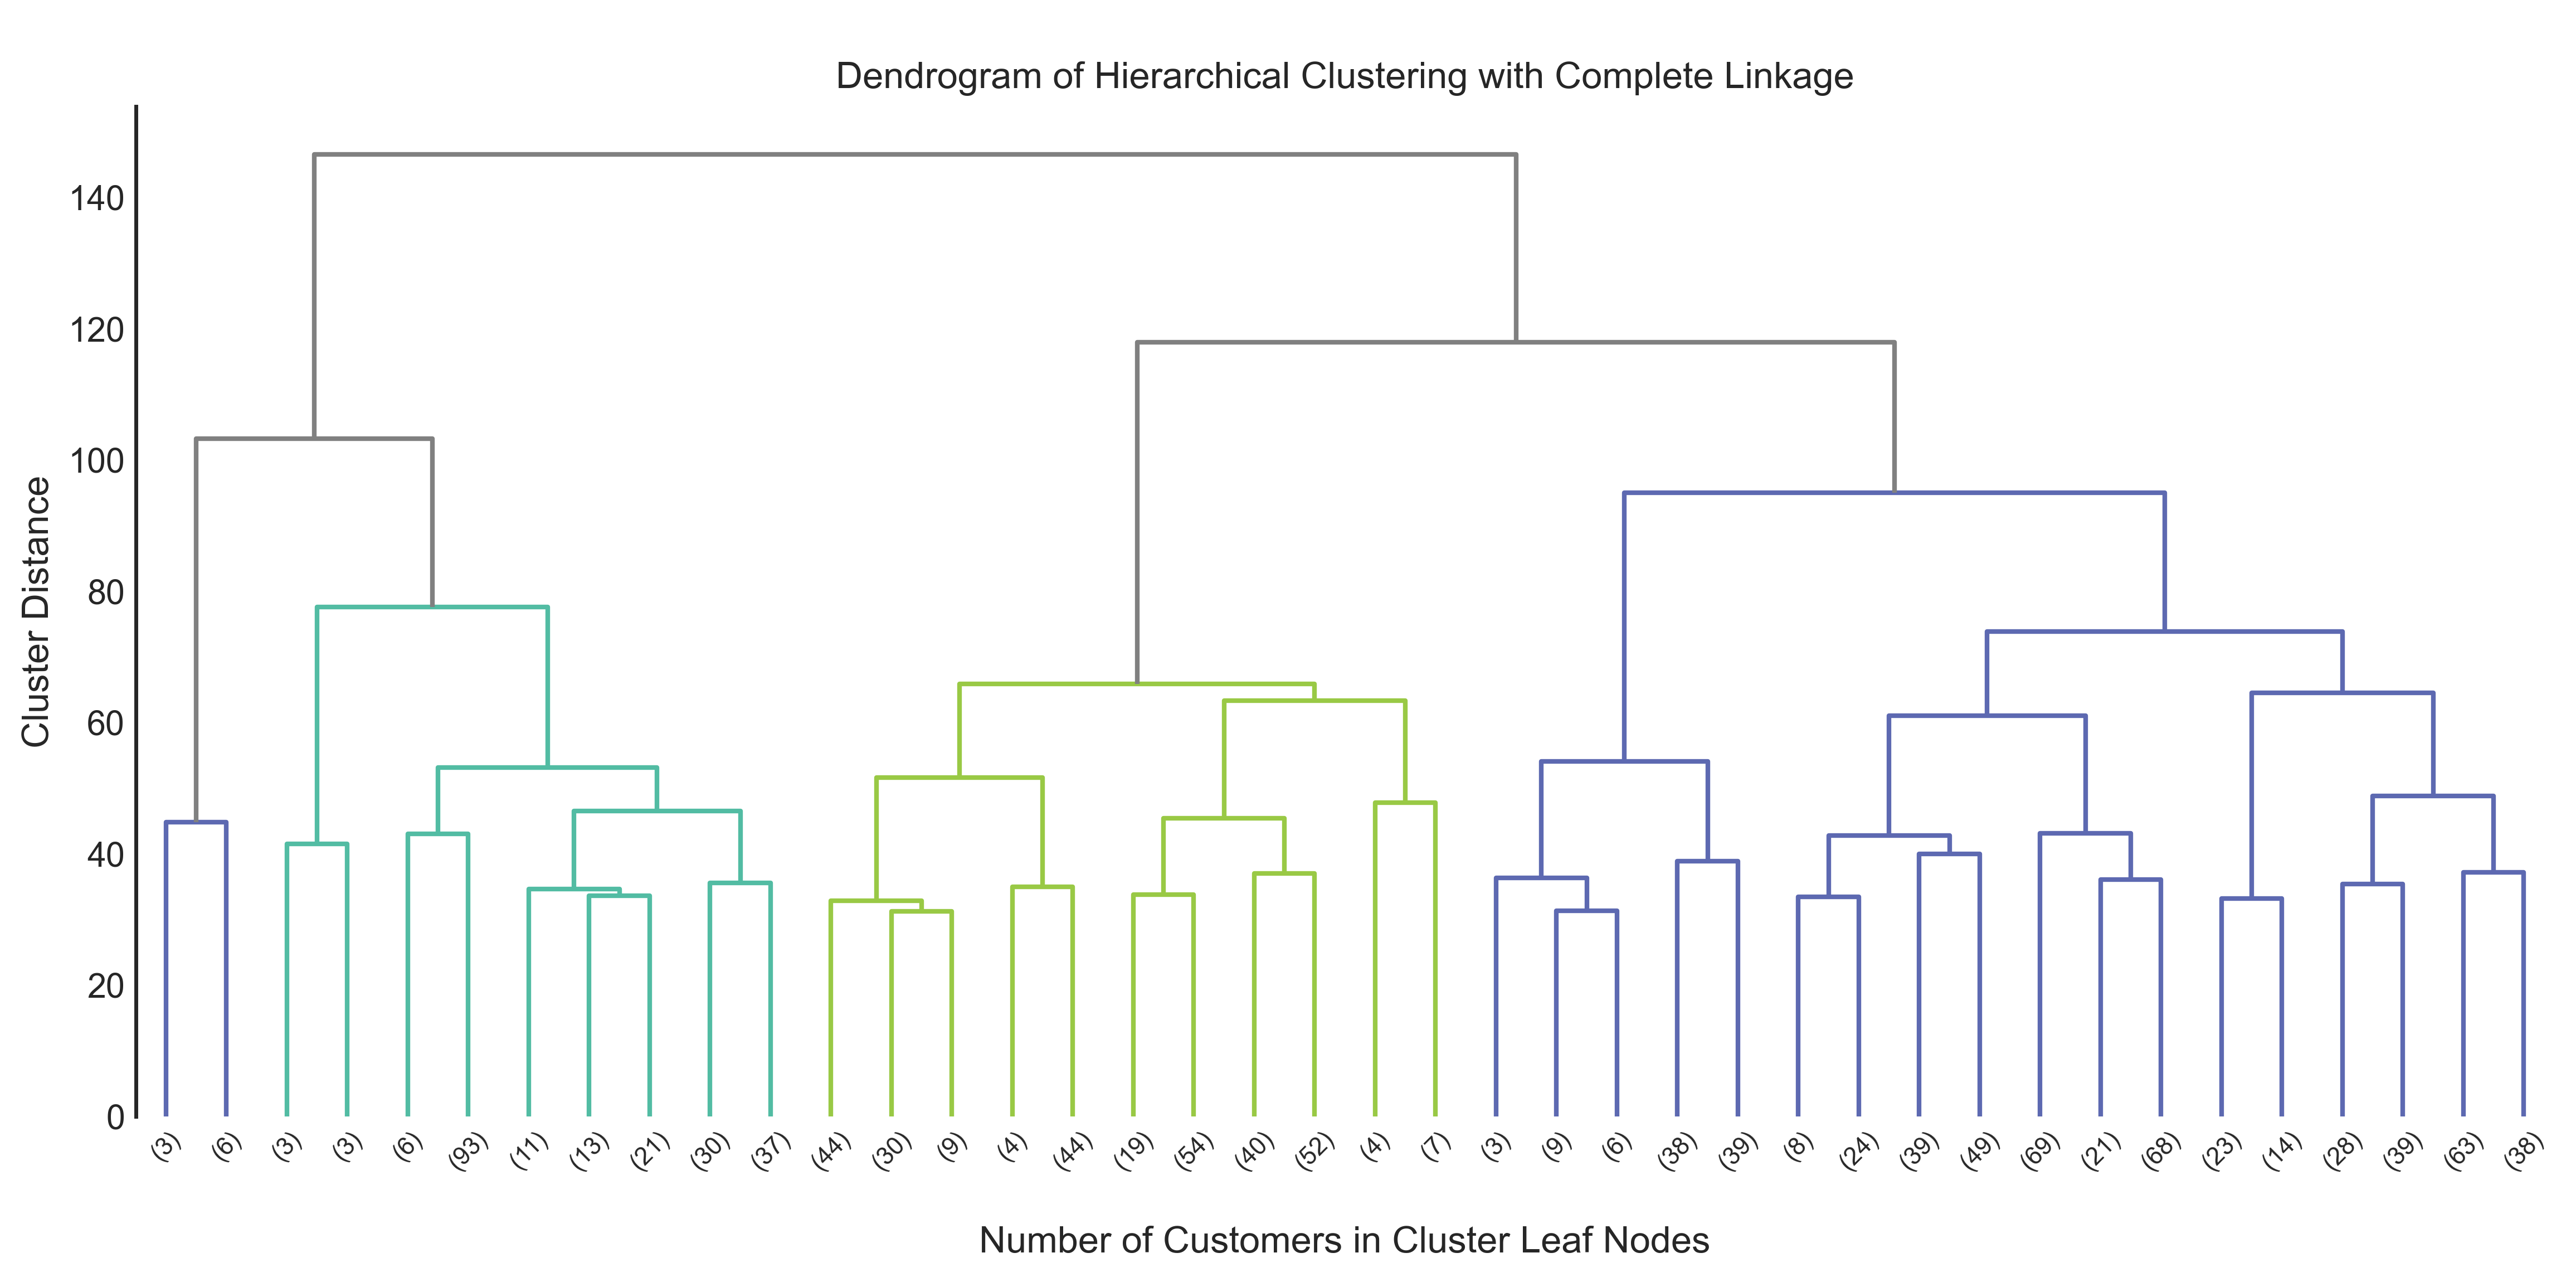

In [11]:
# Dendogram
sns.set(rc={'figure.dpi':400})
sns.set_context('notebook')
sns.set_style('ticks')

Z = hierarchy.linkage(clust_df, method='complete', metric='euclidean')
fig, ax = plt.subplots(figsize=(14,6))
hierarchy.set_link_color_palette(['#5d69b1', '#52bca3', '#99c945'])
den = hierarchy.dendrogram(Z, orientation='top', color_threshold=102,
                           p=40, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color='grey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xlabel('\nNumber of Customers in Cluster Leaf Nodes')
ax.set_ylabel('Cluster Distance')
ax.set_title('\nDendrogram of Hierarchical Clustering with Complete Linkage')
fig.show()

The dendrogram above shows the hierarchical clusters created using complete linkage, which joins pairs of clusters together that have the smallest maximum distance between their observations. The height of the branches indicates how far apart each cluster is and  thus, how different they are. The numbers at the bottom of the tree show how many customers are in each cluster leaf node, with the majority of customers grouped into the first cluster, colored purple. Let's look at the results of the hierarchical clustering based on customer's spending and income.

In [12]:
# Hierarchical clustering
hc = AgglomerativeClustering(3, affinity='euclidean', linkage='complete', compute_full_tree=False)
hc_pred = hc.fit_predict(clust_df)
plot_hc=clust_df.copy()
plot_hc["Hierarchical Cluster"]=hc_pred
plot_hc=plot_hc.sort_values(by='Hierarchical Cluster')
plot_hc['Hierarchical Cluster'] = plot_hc['Hierarchical Cluster'].astype(str)

# Plot of clusters                                               
fig = px.scatter(plot_hc, x="Spending Score", y="Annual Income", color="Hierarchical Cluster",
                 color_discrete_sequence=px.colors.qualitative.Vivid[1:])
fig.update_traces(marker=dict(size=11, opacity=0.75, line=dict(width=1, color='#F7F7F7')))
fig.update_layout(template=temp, title="Hierarchical Cluster Profiles,<br>Customer Spending vs. Income", 
                  width=700, legend_title = 'Cluster',
                  xaxis=dict(title='Spending Score',showline=True, zeroline=False), 
                  yaxis=dict(title='Income, $',ticksuffix='k',showline=True))
fig.show()

Hierarchical clustering tends to put more weight on customer's income in creating the clusters. The medium-sized cluster, Cluster 2, consists of customers who have an annual income of around \\$60,000 or less and spending scores ranging from 2 to 56, while customers in Clusters 1, the largest cluster contain vast range of income but with spending score of 36 to 99 and Cluster 0 have incomes above $70,000 and are further subdivided into smaller segments based on their spending score.

# <div style="color:white;display:fill;border-radius:5px;background-color:#67A4A4;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:120%;text-align:center">Cluster Profile Comparison</p></div>
Below are the plots of the customer profiles based on age, income, and spending from each clustering model.

In [18]:
# Initializing figure with 3 3D subplots
fig = make_subplots(rows=2, cols=1,
                    specs=[[{'type': 'scatter3d'}],
                           [{'type': 'scatter3d'}], 
                          ],
                     subplot_titles=("K-Means Clustering with 5 clusters", 
                                     "Hierarchical Clustering<br>with 3 clusters", 
                                     )
                   )

# Adding clusters to scatterplots 
plot_km['K-Means Cluster'] = plot_km['K-Means Cluster'].astype(int)
plot_km=plot_km.sort_values(by='K-Means Cluster')
for i in range(0,5):
    fig.add_trace(go.Scatter3d(x = plot_km[plot_km['K-Means Cluster'] == i]['Spending Score'],
                               y = plot_km[plot_km['K-Means Cluster'] == i]['Age'],
                               z = plot_km[plot_km['K-Means Cluster'] == i]['Annual Income'],                        
                               mode = 'markers', marker=dict(
                                   size=7,  
                                   color = px.colors.qualitative.Prism[i],
                                   line_width = 1,
                                   line_color='#F7F7F7',
                                   opacity=0.7),
                               name = str('Cluster '+str(i)), legendgroup = 1),
                 row=1, col=1)

plot_hc['Hierarchical Cluster'] = plot_hc['Hierarchical Cluster'].astype(int)
plot_hc=plot_hc.sort_values(by='Hierarchical Cluster')
for i in range(0,3):    
    fig.add_trace(go.Scatter3d(x = plot_hc[plot_hc['Hierarchical Cluster'] == i]['Spending Score'],
                               y = plot_hc[plot_hc['Hierarchical Cluster'] == i]['Age'],
                               z = plot_hc[plot_hc['Hierarchical Cluster'] == i]['Annual Income'],                        
                               mode = 'markers', marker=dict(
                                   size=7,   
                                   color = px.colors.qualitative.Vivid[i+1],
                                   line_width = 1, 
                                   line_color='#F7F7F7',
                                   opacity=0.7),
                               name = str('Hierarchical Cluster '+str(i)), legendgroup = 2), 
                  row=2, col=1)



fig.update_traces(hovertemplate='Customer Spending Score: %{x}<br>Income: $%{z}<br>Age: %{y}')
fig.update_layout(title="Customer Segments based on Income, Spending, and Age",
                  template=temp, height=1800, legend_tracegroupgap = 550,
                  scene=dict(aspectmode='cube',
                             xaxis = dict(title='Spending Score', 
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Age, in years',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='Income, $', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")), 
                  scene2=dict(aspectmode='cube', 
                             xaxis = dict(title='Spending Score',
                                          backgroundcolor="#F3F3F3",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white",),
                             yaxis = dict(title='Age, in years',
                                          backgroundcolor="#E4E4E4",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white"),
                             zaxis = dict(title='Income, $', 
                                          ticksuffix='k',
                                          backgroundcolor="#F6F6F6",
                                          gridcolor="white",
                                          showbackground=True,
                                          zerolinecolor="white")), 

                  )
fig.show()

# <div style="color:white;display:fill;border-radius:5px;background-color:#67A4A4;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:120%;text-align:center">Conclusion</p></div>

In this analysis, two clustering models were developed to explore different types of customers at a supermarket: K-Means Clustering and Hierarchical Clustering. Each model identified distinct customer segments that the company could target depending on their needs. Out of the two clustering techniques, the K-Means model created the more distinguished clusters. The Hierarchical Clustering model defined the fewer number of clusters overall, with more emphasis placed on customer's income. 

Based on customer spending habits, the company could target customers for their membership card program using the two clusters found in the K-Means model, where customers have higher spending scores above 60 and would likely be more inclined to becoming a member. One of the discerning factors between these clusters and the other clusters in the model is that they consist of customers who are under the age of 40, which indicates that the company could aim their membership card marketing program towards customers who are younger than 40 and have higher spending scores. To engage customers with lower spending scores, the company could target these groups with more of their popular products and promotions. In the future, to better understand customer preferences, additional data about the frequency and types of purchases made could be used to further customize product offerings to each segment.

## <b> <span style='color:#707575'>Thank You</span></b>



<img src="https://media-exp1.licdn.com/dms/image/C5603AQGYyFZl05cDqw/profile-displayphoto-shrink_400_400/0/1644006436939?e=1649894400&v=beta&t=FT54XaLZ-qyh8y1xINg4Bk0lFNpfRbAcljZKJ7Q84Bs" class="center" style="height:175px">





BY:

Deep Arora

`SIMS Brand Ambassador`

Symbiosis Institute of Management Studies, Pune


<b><p style='color:#4F9898;text-align:center'></p></b>